In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv


# Data Preprocessing

In [2]:
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv", usecols=lambda col: col != 'id')
print(data.shape)
pd.set_option('display.max_column', None)
data.head()

(568630, 30)


V1        V2        V3        V4        V5        V6        V7  \
0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9       V10       V11       V12       V13       V14  \
0 -0.130006  0.727159  0.637735 -0.987020  0.293438 -0.941386  0.549020   
1 -0.133118  0.347452  0.529808  0.140107  1.564246  0.574074  0.627719   
2 -0.095576 -0.261297  0.690708 -0.272985  0.659201  0.805173  0.616874   
3 -0.065130 -0.205698  0.575231 -0.752581  0.737483  0.592994  0.559535   
4 -0.212660  1.049921  0.968046 -1.203171  1.029577  1.439310  0.241454   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.804879  0.215598  0.512307  0.333644  0.124270  0.091202 -0.110552   
1  0.706121  0.789188  0.403810  0.201799 -0.340687 -0.233984 -0.194936   
2  3.069025 -0.577514  0.886526  0.239442 -2.366079  0.361652 -0.005020   
3 -0.697664 -0.030669  0.242629  2.178616 -1.345060 -0.378223 -0.146927   
4  0.153008  0.224538  0.366466  0.291782  0.445317  0.247237 -0.106984   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.217606 -0.134794  0.165959  0.126280 -0.434824 -0.081230 -0.151045   
1 -0.605761  0.079469 -0.577395  0.190090  0.296503 -0.248052 -0.064512   
2  0.702906  0.945045 -1.154666 -0.605564 -0.312895 -0.300258 -0.244718   
3 -0.038212 -0.214048 -1.893131  1.003963 -0.515950 -0.165316  0.048424   
4  0.729727 -0.161666  0.312561 -0.414116  1.071126  0.023712  0.419117   

     Amount  Class  
0  17982.10      0  
1   6531.37      0  
2   2513.54      0  
3   5384.44      0  
4  14278.97      0

In [3]:
# Taking only small portion of data 
print("Actual Datasize : ",data.shape)
data = data.sample(50000)
print("Reduced Datasize : ",data.shape)

data2 = data.copy()

Actual Datasize :  (568630, 30)
Reduced Datasize :  (50000, 30)


In [4]:
data.isnull().sum()
# Data has no null values

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
cat_cols = data.select_dtypes(include=['object']).columns
print("Categorical Columns ; ", cat_cols)

int_cols = [col for col in data.columns if col not in cat_cols]
print("Non-categorical Columns ; ", int_cols)

Categorical Columns ;  Index([], dtype='object')
Non-categorical Columns ;  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


Column names are not present because They are created in a result of PCA. 

In [6]:
data['Class'].value_counts()
# It displays that values are balanced

Class
0    25089
1    24911
Name: count, dtype: int64

As our data is now transformed and is ready for Data Visulaization and ML Model Creation. 

# Outliers

In [7]:
def iqr_limits(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    return upper, lower

In [8]:
skew, not_skew = [], []

X = data.drop('Class', axis=1)
Y = data['Class']

for col in X.columns:
    sk = data[col].skew()
    print(f"Column [{col}] is {sk:.2f}", end = '\t')
    if sk > - 0.5 and sk < 0.5:
        print(f"{col} is Symmetric")
        not_skew.append(col)
    elif sk > -1 and sk < -1:
        print(f"{col} is Moderately Skewed")
        skew.append(col)
    else:
        print(f"{col} is Skewed")
        skew.append(col)
        

Column [V1] is -0.10	V1 is Symmetric
Column [V2] is -1.38	V2 is Skewed
Column [V3] is 0.00	V3 is Symmetric
Column [V4] is -0.06	V4 is Symmetric
Column [V5] is 1.03	V5 is Skewed
Column [V6] is -0.12	V6 is Symmetric
Column [V7] is 2.86	V7 is Skewed
Column [V8] is 0.28	V8 is Symmetric
Column [V9] is 0.12	V9 is Symmetric
Column [V10] is 0.62	V10 is Skewed
Column [V11] is -0.02	V11 is Symmetric
Column [V12] is 0.07	V12 is Symmetric
Column [V13] is 0.01	V13 is Symmetric
Column [V14] is 0.19	V14 is Symmetric
Column [V15] is 0.05	V15 is Symmetric
Column [V16] is 0.19	V16 is Symmetric
Column [V17] is 0.38	V17 is Symmetric
Column [V18] is 0.12	V18 is Symmetric
Column [V19] is -0.03	V19 is Symmetric
Column [V20] is -2.31	V20 is Skewed
Column [V21] is -0.15	V21 is Symmetric
Column [V22] is 0.33	V22 is Symmetric
Column [V23] is -0.60	V23 is Skewed
Column [V24] is 0.08	V24 is Symmetric
Column [V25] is 0.03	V25 is Symmetric
Column [V26] is -0.02	V26 is Symmetric
Column [V27] is 0.34	V27 is Symmetric


In [9]:
def iqr_method(data, cols):
    results = {}
    for col in cols:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
    
        iqr = q3 - q1
        lower = q1 - (1.5 * iqr)
        upper = q3 + (1.5 * iqr)
        outlier = data[(data[col] < lower) | (data[col] > upper)]
        results[col] = len(outlier)
        print(f"The {col} : {len(outlier)} outliers or {(len(outlier)/len(data))* 100} % outliers")
        data[col] = np.where(data[col] > upper, upper, np.where(data[col] < lower, lower, data[col]))
        print("After Imputation: ")
        outlier = data[(data[col] < lower) | (data[col] > upper)]
        print(f"The {col} : {len(outlier)} outliers or {(len(outlier)/len(data)) * 100} % outliers")
        print("--------------------------------------------------------------------")
    # return outlier

In [10]:
print(f"Columns that are not skew are {len(not_skew)}: ")
print(not_skew)
print("-----------------------------------")
print(f"Columns that are skewed {len(skew)}: ")
print(skew)

Columns that are not skew are 22: 
['V1', 'V3', 'V4', 'V6', 'V8', 'V9', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V21', 'V22', 'V24', 'V25', 'V26', 'V27', 'Amount']
-----------------------------------
Columns that are skewed 7: 
['V2', 'V5', 'V7', 'V10', 'V20', 'V23', 'V28']


## Skewed Data

In [11]:
# Before outlier Removal
plt.figure(figsize=(14, 6))
k=1
for col in skew:
    plt.subplot(2, 4, k)
    sns.boxplot(data= data, x=col, orient='v')
    plt.xlabel(col)
    plt.grid()
    plt.legend()
    k = k+1
plt.tight_layout()
plt.show()
    

In [12]:
# skew_out = 
iqr_method(data, skew)

The V2 : 3923 outliers or 7.846 % outliers
After Imputation: 
The V2 : 0 outliers or 0.0 % outliers
--------------------------------------------------------------------
The V5 : 6204 outliers or 12.408 % outliers
After Imputation: 
The V5 : 0 outliers or 0.0 % outliers
--------------------------------------------------------------------
The V7 : 4971 outliers or 9.942 % outliers
After Imputation: 
The V7 : 0 outliers or 0.0 % outliers
--------------------------------------------------------------------
The V10 : 967 outliers or 1.934 % outliers
After Imputation: 
The V10 : 0 outliers or 0.0 % outliers
--------------------------------------------------------------------
The V20 : 5780 outliers or 11.559999999999999 % outliers
After Imputation: 
The V20 : 0 outliers or 0.0 % outliers
--------------------------------------------------------------------
The V23 : 6465 outliers or 12.93 % outliers
After Imputation: 
The V23 : 0 outliers or 0.0 % outliers
------------------------------------

In [13]:
# After Outlier Removal
plt.figure(figsize=(14, 6))
k=1
for col in skew:
    plt.subplot(3, 3, k)
    sns.boxplot(data= data, x=col, orient='v')
    plt.xlabel(col)
    plt.grid()
    plt.legend()
    k = k+1
plt.tight_layout()
plt.show()
    

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 8))
k=1
for col in skew:
    upper, lower = iqr_limits(data, col)
    plt.subplot(4, 2, k)
    sns.kdeplot(data[col], fill = True, label=f"Imputed {col}")
    sns.kdeplot(data2[col], fill = True, label=col)
    plt.axvline(x=lower, linestyle='--', color='r', label='Lower Limit')
    plt.axvline(x=upper, linestyle='--', color='g', label='Upper Limit')
    plt.xlabel(col)
    plt.grid()

    # plt.xlim([(data2[col].min()) , data2[col].max()])
    plt.legend()
    k +=1

plt.tight_layout()
plt.show()
    

Using Box Plot to Visualize the Outliers. 

## Non-skewed Data

In [15]:
# Before outlier Removal
plt.figure(figsize=(26, 18))
k=1
for col in not_skew:
    plt.subplot(7, 4, k)
    sns.boxplot(data= data, x=col, orient='v')
    plt.xlabel(col)
    plt.grid()
    plt.legend()
    k = k+1
plt.tight_layout()
plt.show()
    

In [16]:
def detect_using_zscore(data, col, threshold=3):
    
    mean = data[col].mean()
    std = data[col].std()
        
    if std == 0:
        print(f"Column '{col}' has zero standard deviation. No outliers possible.")
        return 0,0

    lower_limit = mean - threshold * std
    upper_limit = mean + threshold * std
    return lower_limit, upper_limit

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(48, 30))
k=1
for col in not_skew:
    upper, lower = iqr_limits(data, col)
    plt.subplot(9, 3, k)
    # sns.kdeplot(data[col], fill = True, label=f"Imputed {col}")
    sns.kdeplot(data[col], fill = True, label=col)
    plt.axvline(x=lower, linestyle='--', color='r', label='Lower Limit')
    plt.axvline(x=upper, linestyle='--', color='g', label='Upper Limit')
    plt.xlabel(col)
    plt.grid()

    # plt.xlim([(data2[col].min()) , data2[col].max()])
    plt.legend()
    k +=1

plt.tight_layout()
plt.show()
    

In [18]:
import pandas as pd
import numpy as np

def detect_and_impute_outliers(data, columns, threshold=3):
    if isinstance(columns, set):
        columns = list(columns)
    
    for col in columns:
        if col not in data.columns:
            print(f"Column '{col}' not found in data. Skipping.")
            continue
        
        mean = data[col].mean()
        std = data[col].std()
        
        if std == 0:
            print(f"Column '{col}' has zero standard deviation. No outliers possible.")
            continue
        
        lower_limit = mean - threshold * std
        upper_limit = mean + threshold * std
        
        # Count initial outliers
        num_outliers = ((data[col] < lower_limit) | (data[col] > upper_limit)).sum()
        
        print(f"For column '{col}':")
        # print(f"  Mean: {mean:.4f}")
        # print(f"  Std: {std:.4f}")
        print(f"  Lower limit (outlier if below): {lower_limit:.4f}")
        print(f"  Upper limit (outlier if above): {upper_limit:.4f}")
        print(f"  Number of outliers before imputation: {num_outliers}")
        
        # Impute by clipping
        data[col] = np.where(data[col] > upper_limit, upper_limit, np.where(data[col] < lower_limit, lower_limit, data[col]))
        
        # Recount outliers to confirm
        num_outliers_after = ((data[col] < lower_limit) | (data[col] > upper_limit)).sum()
        print(f"  Number of outliers after imputation: {num_outliers_after}")
        print("---"*15)

In [19]:
detect_and_impute_outliers(data, not_skew)

For column 'V1':
  Lower limit (outlier if below): -3.0031
  Upper limit (outlier if above): 3.0075
  Number of outliers before imputation: 1
  Number of outliers after imputation: 0
---------------------------------------------
For column 'V3':
  Lower limit (outlier if below): -2.9978
  Upper limit (outlier if above): 2.9982
  Number of outliers before imputation: 112
  Number of outliers after imputation: 0
---------------------------------------------
For column 'V4':
  Lower limit (outlier if below): -3.0270
  Upper limit (outlier if above): 3.0119
  Number of outliers before imputation: 110
  Number of outliers after imputation: 0
---------------------------------------------
For column 'V6':
  Lower limit (outlier if below): -3.0080
  Upper limit (outlier if above): 3.0052
  Number of outliers before imputation: 538
  Number of outliers after imputation: 0
---------------------------------------------
For column 'V8':
  Lower limit (outlier if below): -3.0266
  Upper limit (outl

# Data Visulization

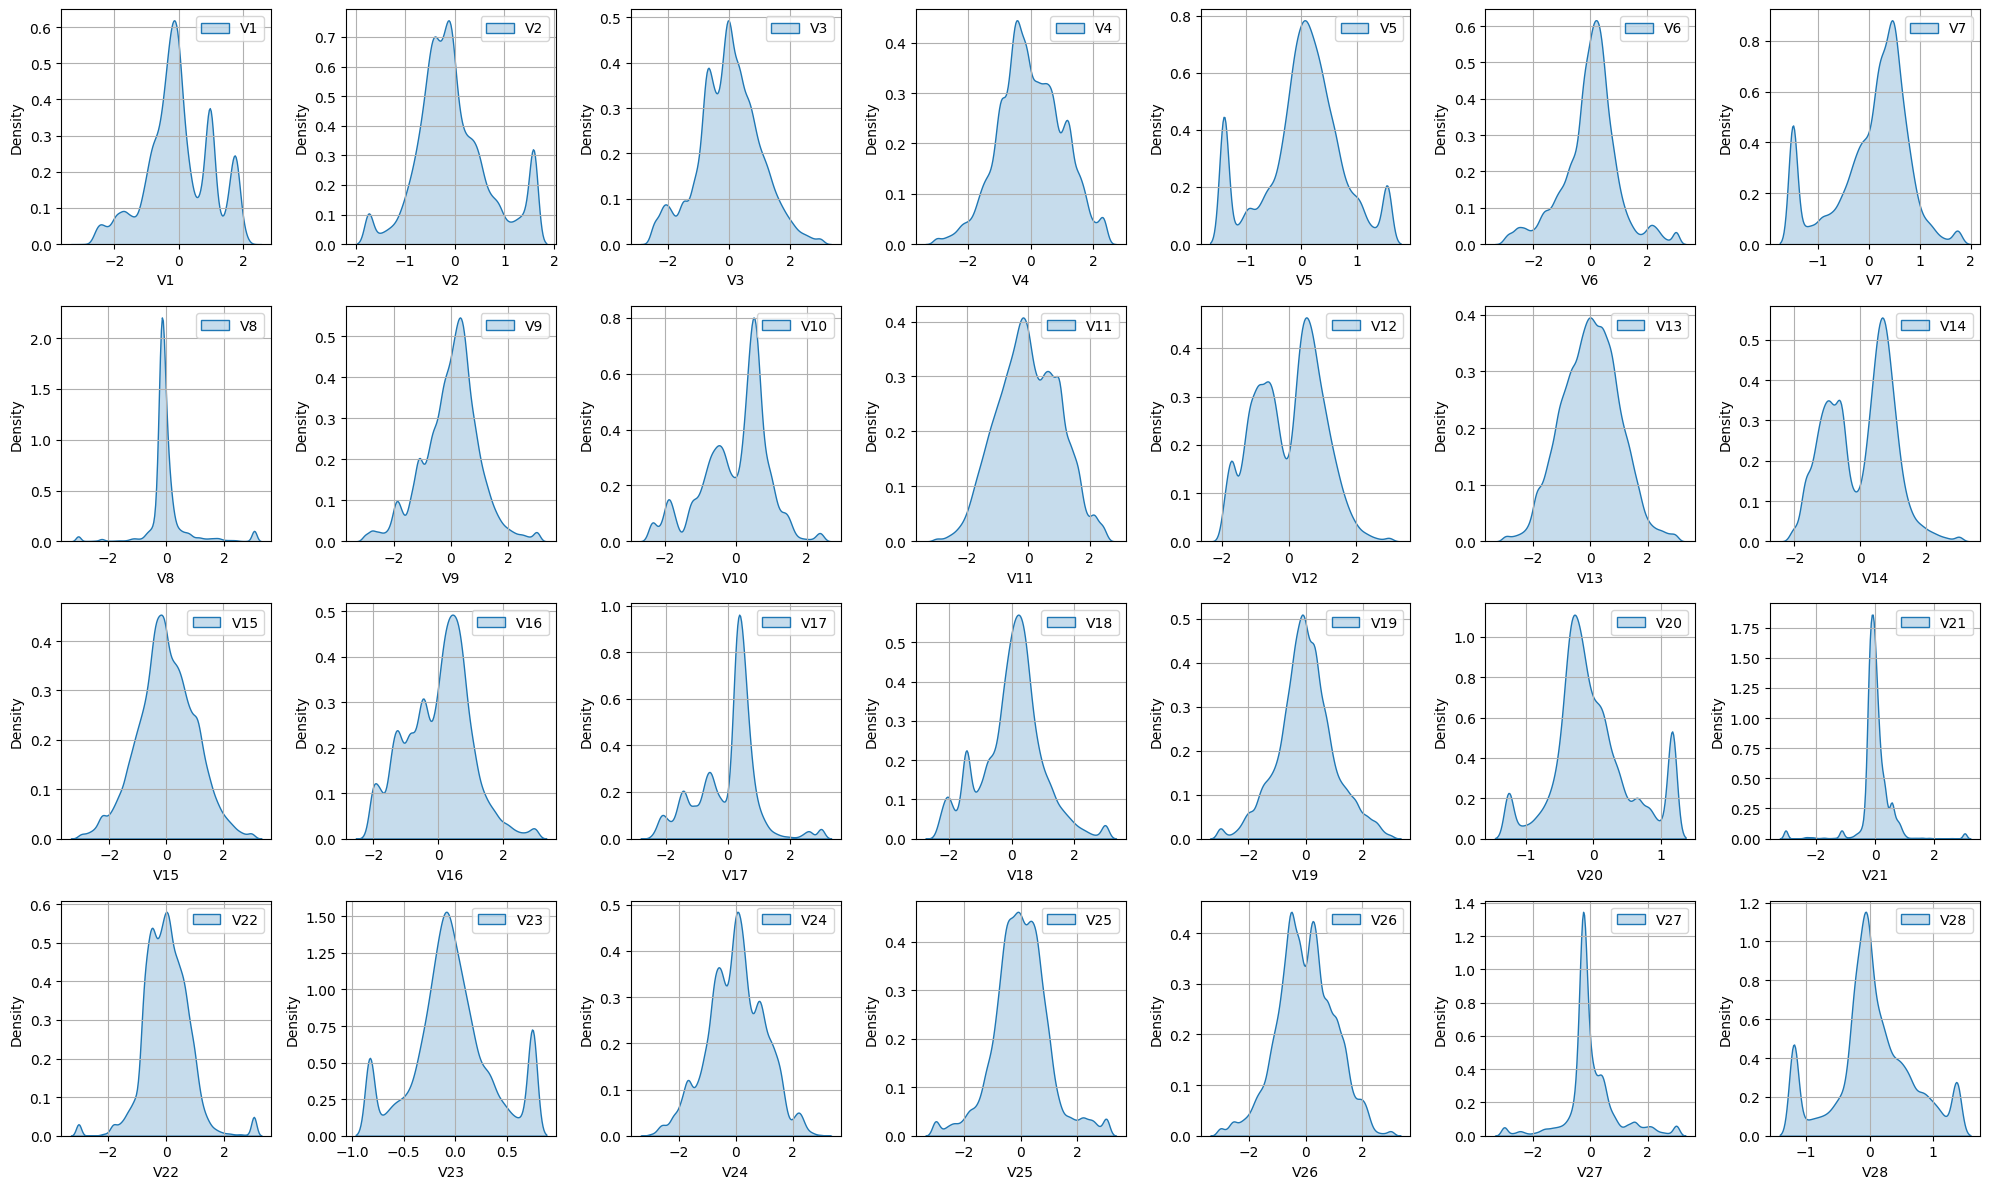

In [20]:
import seaborn as sns

v = []
for i in range(1, 29):
    add = "V" + str(i)
    v.append(add)
    
# from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 12))
j = 1
for val in v:
    plt.subplot(4, 7, j)
    sns.kdeplot(data[val], fill = True, label=val)
    plt.xlabel(val)
    plt.grid()
    plt.legend()
    j = j+1

plt.tight_layout()
plt.show()


In [21]:
sns.kdeplot(data=data, x='Amount', fill=True)
plt.grid()

In [22]:
binn = [0, 1000, 2500, 5000, 10000, 15000, 20000, 25000]
labels = ['Under 1k', '1k to 2.5k', '2.5k to 5k', '5k to 10k', '10k to 15k', '15k to 20k', '20k to 25k']
data['Amount_in_bins'] = pd.cut(data['Amount'], labels = labels, bins=binn)

Text(0, 0.5, 'No. of Transactions')

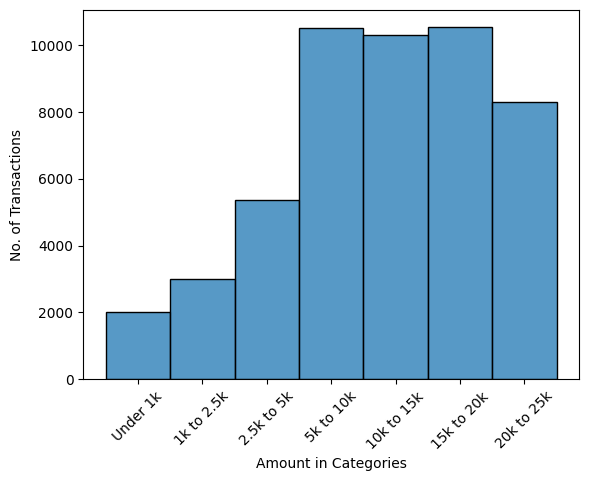

In [23]:
sns.histplot(data['Amount_in_bins'])
plt.xticks(rotation=45)
plt.xlabel("Amount in Categories")
plt.ylabel("No. of Transactions")

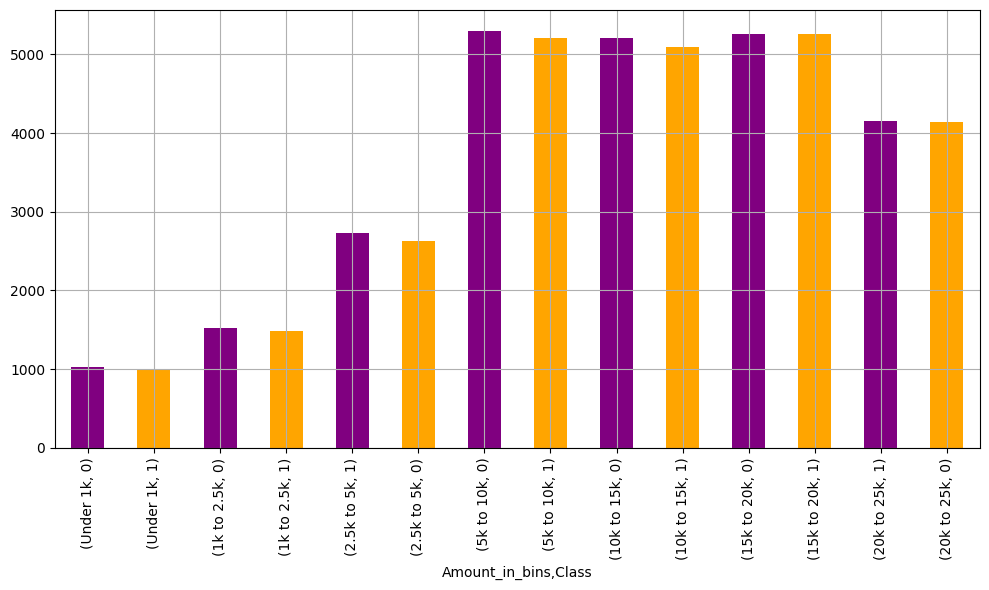

In [24]:
plt.figure(figsize=(10,6))
color = ['purple', 'orange', 'purple', 'orange']
(data.groupby('Amount_in_bins')['Class'].value_counts()).plot(kind='bar', color=color)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

In [25]:
data.groupby('Amount_in_bins')['Class'].value_counts()


Amount_in_bins  Class
Under 1k        0        1030
                1         987
1k to 2.5k      0        1518
                1        1482
2.5k to 5k      1        2727
                0        2630
5k to 10k       0        5299
                1        5212
10k to 15k      0        5203
                1        5094
15k to 20k      0        5265
                1        5259
20k to 25k      1        4150
                0        4144
Name: count, dtype: int64

In [26]:
i=0
fraud_by_bin = data.groupby('Amount_in_bins')['Class'].value_counts()
for val in labels:
    non_fraud = fraud_by_bin[i]/(fraud_by_bin[i] + fraud_by_bin[i+1])
    fraud = fraud_by_bin[i+1]/(fraud_by_bin[i] + fraud_by_bin[i+1])
    print(f"Chances of Fraud when transaction of {val} is made is : {fraud*100:.2f}%")
    print(f"Chances of not_Fraud when transaction of {val} is made is : {non_fraud*100:.2f}%")
    i=i+2
    print("----"*20)
    

Chances of Fraud when transaction of Under 1k is made is : 48.93%
Chances of not_Fraud when transaction of Under 1k is made is : 51.07%
--------------------------------------------------------------------------------
Chances of Fraud when transaction of 1k to 2.5k is made is : 49.40%
Chances of not_Fraud when transaction of 1k to 2.5k is made is : 50.60%
--------------------------------------------------------------------------------
Chances of Fraud when transaction of 2.5k to 5k is made is : 49.09%
Chances of not_Fraud when transaction of 2.5k to 5k is made is : 50.91%
--------------------------------------------------------------------------------
Chances of Fraud when transaction of 5k to 10k is made is : 49.59%
Chances of not_Fraud when transaction of 5k to 10k is made is : 50.41%
--------------------------------------------------------------------------------
Chances of Fraud when transaction of 10k to 15k is made is : 49.47%
Chances of not_Fraud when transaction of 10k to 15k is

<Axes: >

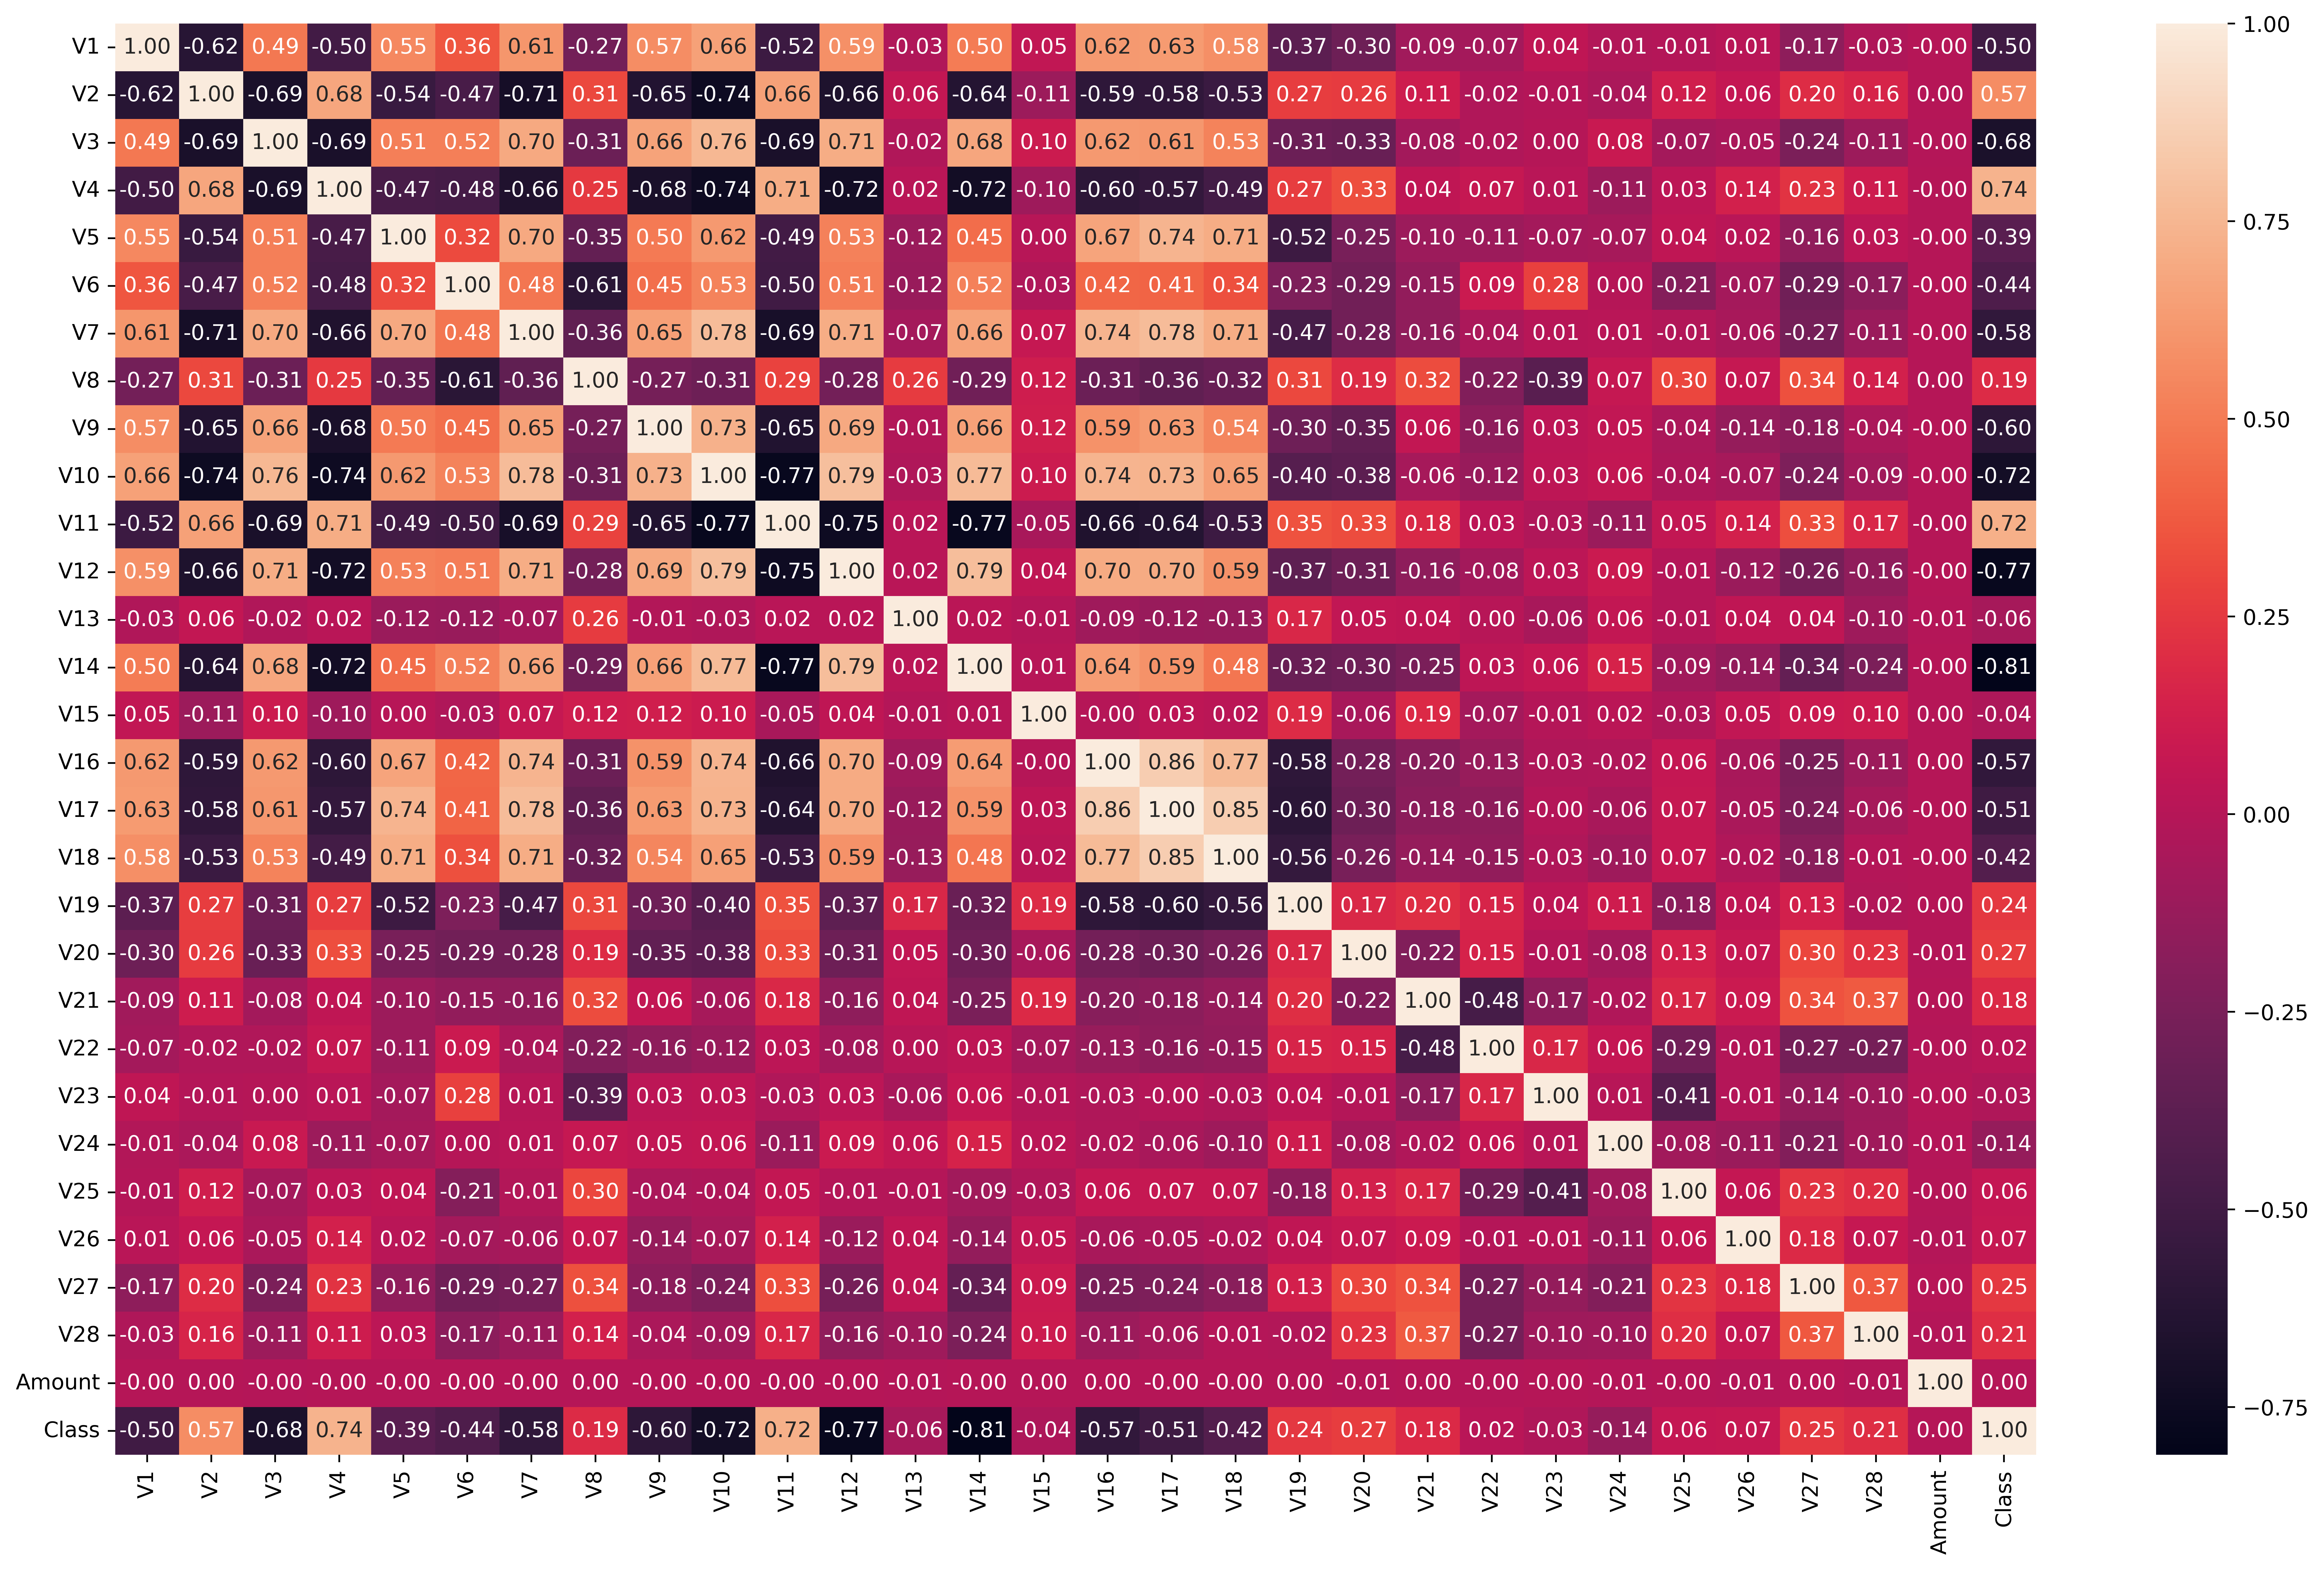

In [27]:
all_num = [col for col in data.columns if col != 'Amount_in_bins']
plt.figure(figsize=(20,12), dpi =500)
sns.heatmap(data[all_num].corr(), annot=True,fmt=".2f")


<Axes: ylabel='count'>

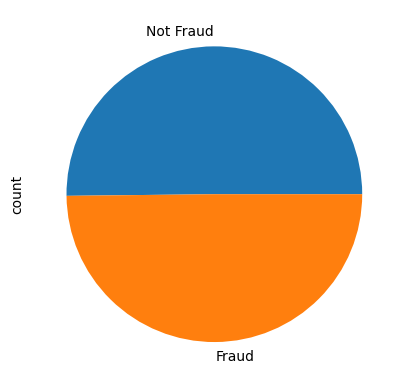

In [28]:
data['Class'].value_counts().plot(kind='pie', labels=[ 'Not Fraud', 'Fraud'])


# Model Building

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = data2.drop('Class', axis=1)
Y = data2['Class']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
st = StandardScaler()
X_train = st.fit_transform(X_train)
X_test = st.transform(X_test)